In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

- In this introductory example, you will see how to use the :code:`spikeinterface` to perform a full electrophysiology analysis.
- We will first create some simulated data, and we will then perform some pre-processing, run a couple of spike sorting algorithms, inspect and validate the results, export to Phy, and compare spike sorters.


In [42]:
from collections import defaultdict
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd

In [43]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [44]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [45]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [46]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [47]:
import spikeinterface.full as si

In [48]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

## Part 1: Importing Data

### Looking at Metadata

- Looking over the metadata file. This gives us:
    - Original file name
    - Clock Rate
    - Decimation
    - Number of Channels
- **NOTE**: If you are not doing the example, then change the file paths used

In [52]:
with open("./example/recording/02122021_BLA4-1_1v2_Competition_Day1.info.dat") as info_file:
    lines = info_file.readlines()
    for line in lines:
        print(line)

<Start settings>

Description: Channel info for PHY data

Byte_order: little endian

Original_file: 02122021_BLA4-1_1v2_Competition_Day1.rec

Clock rate: 20000

Decimation: 1

Number_of_channels: 32

Fields: <nTrode int16><nTrodeChannel int16>

<End settings>

                       	   

         

                                                             


### Loading in the Electrophysiology Recording

- Reading in the data into Spikeinterface
    - If you are using a different look at https://spikeinterface.readthedocs.io/en/latest/modules/extractors/plot_1_read_various_formats.html#sphx-glr-modules-extractors-plot-1-read-various-formats-py
    - You can also try tab completing `se.read_` and see what other electrophysiology data formats are accepted

- All the different options for importing electrophysiology data

In [64]:
for method in dir(se):
    if method.startswith("read"):
        print(method)

read_alf_sorting
read_bids_folder
read_blackrock
read_ced
read_combinato
read_hdsort
read_herdingspikes
read_intan
read_kilosort
read_klusta
read_maxwell
read_maxwell_event
read_mcsraw
read_mda_recording
read_mda_sorting
read_mearec
read_neuralynx
read_neuroscope
read_nix
read_nwb
read_nwb_recording
read_nwb_sorting
read_openephys
read_phy
read_plexon
read_shybrid_recording
read_shybrid_sorting
read_spike2
read_spikegadgets
read_spikeglx
read_spykingcircus
read_tridesclous
read_waveclust
read_yass


In [65]:
recording = se.read_spikegadgets("./example/recording/02122021_BLA4-1_1v2_Competition_Day1.rec")

This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


In [66]:
type(recording)

spikeinterface.extractors.neoextractors.spikegadgets.SpikeGadgetsRecordingExtractor

:code:`recording` is a :code:`RecordingExtractor` object, which extracts information about channel ids, channel locations
(if present), the sampling frequency of the recording, and the extracellular  traces. :code:`sorting_true` is a
:code:`SortingExtractor` object, which contains information about spike-sorting related information,  including unit ids,
spike trains, etc. Since the data are simulated, :code:`sorting_true` has ground-truth information of the spiking
activity of each unit.

Let's use the :code:`widgets` module to visualize the traces and the raster plots.



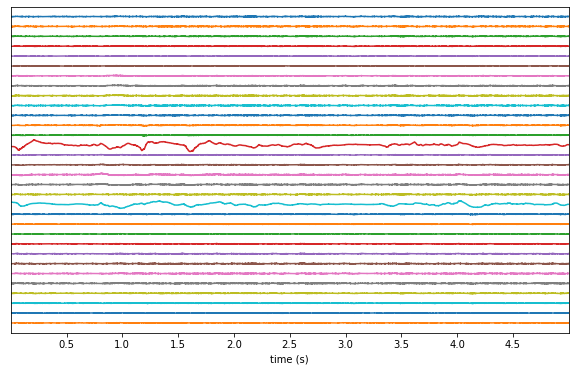

In [12]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 5))


This is how you retrieve info from a :code:`RecordingExtractor`...



In [13]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()
duration = recording.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 66378757
Number of hours: 0.9219271805555554


...and a :code:`SortingExtractor`



In [14]:
num_seg = recording.get_num_segments()

print('Number of segments:', num_seg)

Number of segments: 1


:code:`spikeinterface` internally uses the :code:`probeinterface`
to handle Probe and ProbeGroup.
 So any probe in the probeinterface collections can be download
and set to a Recording object.
In this case, the MEArec dataset already handles a Probe and we don't need to set it.



Using the :code:`toolkit`, you can perform preprocessing on the recordings.
Each pre-processing function also returns a :code:`RecordingExtractor`,
which makes it easy to build pipelines. Here, we filter the recording and
apply common median reference (CMR).
All theses preprocessing steps are "lazy". The computation is done on demand when we call
`recording.get_traces(...)` or when we save the object to disk.



# Part 2: Setting Probes

In [15]:
# importing the module
import json

In [16]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe

## Opening up relevant Probe Metadata

In [17]:
with open("/nancy/user/riwata/projects/spike_sorting/results/2022_06_01_visualization/data/probe/nancyparameters.prm") as info_file:
    lines = info_file.readlines()
    for line in lines:
        print(line)

experiment_name = '02122021_BLA4-1_1v2_Competition_Day1.phy'

prb_file = 'nancyprobe_linearprobelargespace.prb'  # or the path to your PRB file



traces = dict(

    raw_data_files=[experiment_name + '.dat'],  # path to your .dat file(s)

    sample_rate=20000,  # sampling rate in Hz

    n_channels=32,  # number of channels in the .dat files

    dtype='int16',  # the data type used in the .dat files

)



# Parameters for the spike detection process.

spikedetekt = dict(



    filter_high_factor=0.95 * .5,

    filter_butter_order=3,  # Order of Butterworth filter.





    chunk_size_seconds=1,

    chunk_overlap_seconds=.015,



    n_excerpts=50,

    excerpt_size_seconds=1,

    threshold_strong_std_factor=3.5,

    threshold_weak_std_factor=3,

    detect_spikes='positive',

    use_single_threshold=True,

    connected_component_join_size=1,



    extract_s_before=10,

    extract_s_after=15,



    n_features_per_channel=3,  # Number of features per channel.

    pca_n_wave

In [18]:
with open("/nancy/user/riwata/projects/spike_sorting/results/2022_06_01_visualization/data/probe/nancyprobe_linearprobelargespace.prb") as info_file:
    lines = info_file.readlines()
    for line in lines:
        print(line)

channel_groups = {0: {'channels': [0,

                  1,

                  2,

                  3,

                  4,

                  5,

                  6,

                  7,

                  8,

                  9,

                  10,

                  11,

                  12,

                  13,

                  14,

                  15,

                  16,

                  17,

                  18,

                  19,

                  20,

                  21,

                  22,

                  23,

                  24,

                  25,

                  26,

                  27,

                  28,

                  29,

                  30,

                  31],

     'geometry':{

    0: (0, 0),

    1: (5, 20),

    2: (-7, 40),

    3: (9, 60),

    4: (-11, 80),

    5: (13, 100),

    6: (-15, 120),

    7: (17, 140),

    8: (-19, 160),

    9: (21, 180),

    10: (-23, 200),

    11: (25, 220),

    12: (-27

- TODO: Create a probe group: https://probeinterface.readthedocs.io/_/downloads/en/latest/pdf/

## Making a probe from scratch

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from probeinterface import Probe, ProbeGroup
from probeinterface import Probe
from probeinterface.plotting import plot_probe_group
from probeinterface.plotting import plot_probe

In [20]:
from probeinterface import generate_linear_probe, generate_multi_shank
from probeinterface.generator import generate_tetrode
from probeinterface.generator import generate_linear_probe
from probeinterface.generator import generate_multi_columns_probe

- Making 8 tetrodes for 32 channels

In [21]:
import itertools

In [22]:
probegroup = ProbeGroup()
x_difference = [0, 40, 80, 120]
y_difference = [0, 40]
difference_combinations = list(itertools.product(x_difference, y_difference))

for num in range(8):   
    current_tetrode = generate_tetrode()
    current_tetrode.move([difference_combinations[num][0], difference_combinations[num][1]])
    probegroup.add_probe(current_tetrode)

probegroup.set_global_device_channel_indices(np.arange(32))

In [23]:
probegroup.get_channel_count()

32

In [24]:
probegroup.get_global_device_channel_indices()

array([(0,  0), (0,  1), (0,  2), (0,  3), (1,  4), (1,  5), (1,  6),
       (1,  7), (2,  8), (2,  9), (2, 10), (2, 11), (3, 12), (3, 13),
       (3, 14), (3, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 20),
       (5, 21), (5, 22), (5, 23), (6, 24), (6, 25), (6, 26), (6, 27),
       (7, 28), (7, 29), (7, 30), (7, 31)],
      dtype=[('probe_index', '<i8'), ('device_channel_indices', '<i8')])

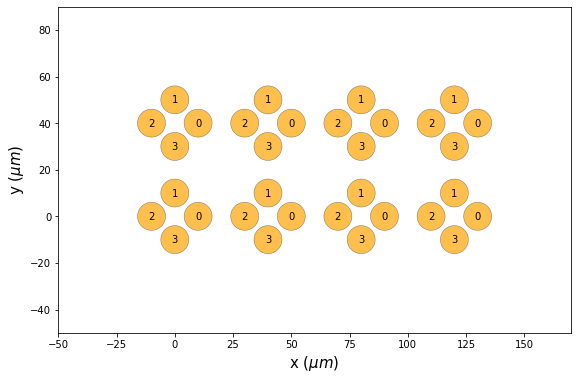

In [25]:
plot_probe_group(probegroup, same_axes=True, with_channel_index=True)

In [26]:
probegroup.to_dataframe()

,probe_index,x,y,contact_shapes,radius,shank_ids,contact_ids
0,0,1.000000e+01,0.000000e+00,circle,6.0,,
1,0,6.123234e-16,1.000000e+01,circle,6.0,,
2,0,-1.000000e+01,1.224647e-15,circle,6.0,,
3,0,-1.836970e-15,-1.000000e+01,circle,6.0,,
4,1,1.000000e+01,4.000000e+01,circle,6.0,,
5,1,6.123234e-16,5.000000e+01,circle,6.0,,
6,1,-1.000000e+01,4.000000e+01,circle,6.0,,
7,1,-1.836970e-15,3.000000e+01,circle,6.0,,
8,2,5.000000e+01,0.000000e+00,circle,6.0,,
9,2,4.000000e+01,1.000000e+01,circle,6.0,,


### Multishank Probe

In [27]:
multi_shank = generate_multi_shank(num_shank=32, num_columns=1, num_contact_per_column=1)

(<matplotlib.collections.PolyCollection at 0x7f9859a20a10>,
 <matplotlib.collections.PolyCollection at 0x7f985985a750>)

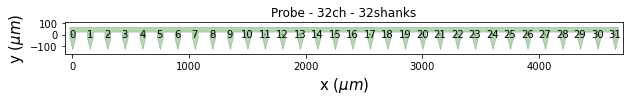

In [28]:
plot_probe(multi_shank, with_channel_index=True)

In [29]:
multi_shank.set_device_channel_indices(np.arange(32))

In [30]:
recording = recording.set_probes(multi_shank)

This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


# Part 3: Preprocessing

- With Maya's preprocessing method

In [31]:
# Bandpass Filtering
recording_f = st.bandpass_filter(recording, freq_min=300, freq_max=6000)
print(recording_f)

BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s


In [32]:
recording_rm_noise = st.preprocessing.remove_bad_channels(recording_f)
print(recording_rm_noise)

RemoveBadChannelsRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s


In [33]:
# Re-referencing
recording_cmr = st.common_reference(recording_rm_noise, reference='global', operator='median')
print(recording_cmr)


CommonReferenceRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s


## Visualization and EDA

(11.0, 16.0, -2636.25, 84360.0)

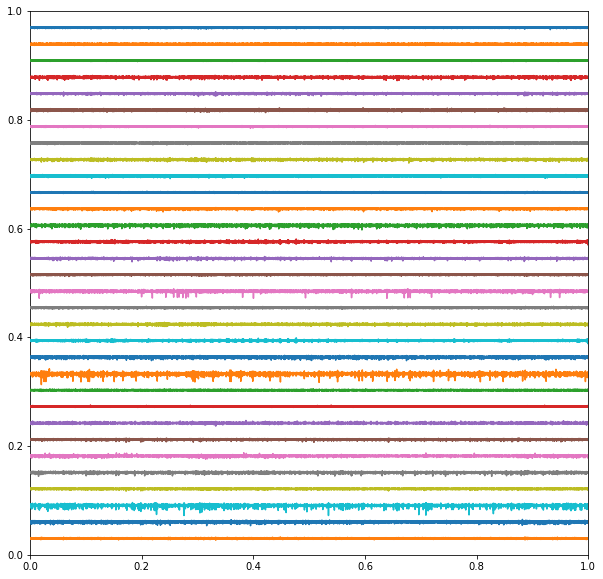

In [34]:
plt_kwargs = {'linewidth': 0.05}
fig, ax = plt.subplots(1,1, figsize=(10,10), **plt_kwargs)
sw.plot_timeseries(recording_cmr, time_range=[11,16], figure=fig)
plt.axis('off')

(11.0, 16.0, -854.25, 3417.0)

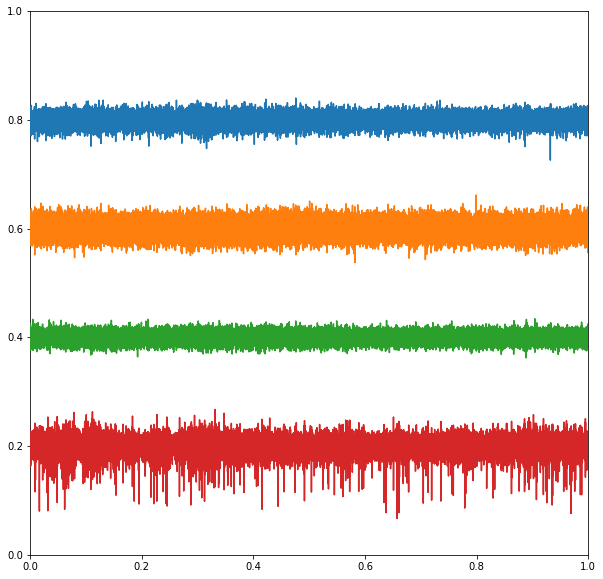

In [35]:
plt_kwargs = {'linewidth': 0.05}
fig, ax = plt.subplots(1,1, figsize=(10,10), **plt_kwargs)
sw.plot_timeseries(recording_cmr, time_range=[11,16], figure=fig,
                  channel_ids=['0', '1', '2', '3'])
plt.axis('off')

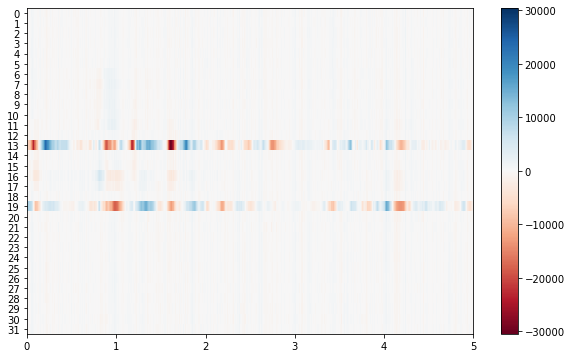

In [36]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 5), mode="map", show_channel_ids=True,)


`ValueError: There is not Probe attached to recording. use set_probe(...)`

# Part 4: Sorting

Now you are ready to spike sort using the :code:`sorters` module!
Let's first check which sorters are implemented and which are installed



In [37]:
print('Available sorters', ss.available_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'pykilosort', 'spykingcircus', 'tridesclous', 'waveclus', 'yass']


The :code:`ss.installed_sorters()` will list the sorters installed in the machine.
We can see we have mountainsort4 and Tridesclous installed.
Spike sorters come with a set of parameters that users can change.
The available parameters are dictionaries and can be accessed with:



In [38]:
print(ss.get_default_params('mountainsort4'))

{'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'num_workers': 1, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10}


Let's run mountainsort4 and change one of the parameter, say, the detect_threshold:



In [39]:
ms4_params = ss.get_default_params('mountainsort4').copy()

In [40]:
ms4_params['adjacency_radius'] = 100
ms4_params['detect_sign'] = 0
ms4_params['filter'] = False
ms4_params['num_workers'] = 8
ms4_params['detect_interval'] = 30

In [41]:
sorting_ms4 = ss.read_sorter_folder("./proc/mountainsort4_output")